In [ ]:
%pip install torch torchvision torchaudio
%pip install pillow matplotlib numpy timm


In [1]:
import torch
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import torchvision.transforms as transforms
import timm
import torch.nn.functional as F

device = torch.device("mps")
print(f"Using device: {device}")

TRAIN_SIZE = 384
INFERENCE_SIZE = 1600

transform = transforms.Compose([
    transforms.Resize((INFERENCE_SIZE, INFERENCE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def interpolate_pos_embed(model, new_size):
    """Interpolate positional embeddings to support different input sizes"""
    pos_embed = model.pos_embed
    num_extra_tokens = 1
    
    old_size = int((pos_embed.shape[1] - num_extra_tokens) ** 0.5)
    new_grid_size = new_size // 16
    
    if old_size == new_grid_size:
        return
    
    print(f"  Interpolating pos_embed: {old_size}x{old_size} -> {new_grid_size}x{new_grid_size}")
    
    cls_token = pos_embed[:, :num_extra_tokens]
    pos_tokens = pos_embed[:, num_extra_tokens:]
    pos_tokens = pos_tokens.reshape(1, old_size, old_size, -1).permute(0, 3, 1, 2)
    
    pos_tokens = torch.nn.functional.interpolate(
        pos_tokens, size=(new_grid_size, new_grid_size), 
        mode='bicubic', align_corners=False
    )
    pos_tokens = pos_tokens.permute(0, 2, 3, 1).flatten(1, 2)
    
    new_pos_embed = torch.cat([cls_token, pos_tokens], dim=1)
    model.pos_embed = torch.nn.Parameter(new_pos_embed)
    
    model.patch_embed.img_size = (new_size, new_size)
    model.patch_embed.grid_size = (new_grid_size, new_grid_size)
    model.patch_embed.num_patches = new_grid_size * new_grid_size

def load_model(checkpoint_path=None, inference_size=INFERENCE_SIZE):
    """Load base or finetuned DINOv3 model"""
    checkpoint_size = TRAIN_SIZE
    
    if checkpoint_path:
        state_dict = torch.load(checkpoint_path, map_location=device)
        if 'student' in state_dict:
            state_dict = state_dict['student']
        elif 'model' in state_dict:
            state_dict = state_dict['model']
        elif 'state_dict' in state_dict:
            state_dict = state_dict['state_dict']
        
        if 'pos_embed' in state_dict:
            num_patches = state_dict['pos_embed'].shape[1] - 1
            grid_size = int(num_patches ** 0.5)
            checkpoint_size = grid_size * 16
            print(f"Detected checkpoint trained at: {checkpoint_size}x{checkpoint_size}")
    
    model = timm.create_model('vit_large_patch16_384', pretrained=False, num_classes=0, img_size=checkpoint_size)
    
    if checkpoint_path:
        model.load_state_dict(state_dict, strict=False)
    
    if inference_size != checkpoint_size:
        interpolate_pos_embed(model, inference_size)
    
    model = model.to(device)
    model.eval()
    return model

def extract_features(model, img_path):
    """Extract dense features from an image"""
    img = Image.open(img_path).convert('RGB')
    img_tensor = transform(img).unsqueeze(0).to(device)
    
    with torch.no_grad():
        features = model.forward_features(img_tensor)
        if len(features.shape) == 3:
            features = features[:, 1:, :]
    
    return features.squeeze().cpu().numpy(), img

def compute_similarity_map(features, point_x, point_y, img_size=INFERENCE_SIZE):
    """Compute cosine similarity map for a selected point"""
    grid_size = img_size // 16
    features_grid = features.reshape(grid_size, grid_size, -1)
    
    # Convert pixel coordinates to patch coordinates
    patch_x = int((point_x / img_size) * grid_size)
    patch_y = int((point_y / img_size) * grid_size)
    patch_x = np.clip(patch_x, 0, grid_size - 1)
    patch_y = np.clip(patch_y, 0, grid_size - 1)
    
    # Get feature vector for selected point
    query_feature = features_grid[patch_y, patch_x]
    
    # Flatten features for similarity computation
    features_flat = features.reshape(-1, features.shape[-1])
    
    # Compute cosine similarity (raw values, not softmax)
    query_norm = query_feature / (np.linalg.norm(query_feature) + 1e-8)
    features_norm = features_flat / (np.linalg.norm(features_flat, axis=1, keepdims=True) + 1e-8)
    similarity = np.dot(features_norm, query_norm)
    
    # Reshape to grid
    similarity_map = similarity.reshape(grid_size, grid_size)
    
    return similarity_map, (patch_x, patch_y)

def visualize_similarity(img_path, point_x, point_y, base_model, finetuned_model):
    """Visualize similarity maps for base and finetuned models"""
    # Extract features
    base_features, original_img = extract_features(base_model, img_path)
    finetuned_features, _ = extract_features(finetuned_model, img_path)
    
    # Compute similarity maps (cosine similarity values)
    base_sim, patch_coords = compute_similarity_map(base_features, point_x, point_y)
    finetuned_sim, _ = compute_similarity_map(finetuned_features, point_x, point_y)
    
    # Normalize to 0-1 range within each map for better visualization
    base_norm = (base_sim - base_sim.min()) / (base_sim.max() - base_sim.min() + 1e-8)
    ft_norm = (finetuned_sim - finetuned_sim.min()) / (finetuned_sim.max() - finetuned_sim.min() + 1e-8)
    
    # Apply power transform to emphasize high similarities (like in the reference)
    # Higher power = more contrast, more blue background
    power = 10
    base_vis = np.power(base_norm, power)
    ft_vis = np.power(ft_norm, power)
    
    print(f"Base similarity: [{base_sim.min():.4f}, {base_sim.max():.4f}]")
    print(f"Finetuned similarity: [{finetuned_sim.min():.4f}, {finetuned_sim.max():.4f}]")
    
    # Create figure
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Original image with selected point
    axes[0].imshow(original_img)
    axes[0].plot(point_x, point_y, 'r+', markersize=20, markeredgewidth=3)
    axes[0].set_title('Original Image\n(Selected Point)', fontsize=14)
    axes[0].axis('off')
    
    # Base DINO similarity
    im1 = axes[1].imshow(base_vis, cmap='jet', vmin=0, vmax=1)
    axes[1].set_title('Base DINO\nSimilarity Map', fontsize=14)
    axes[1].axis('off')
    plt.colorbar(im1, ax=axes[1], fraction=0.046)
    
    # Finetuned DINO similarity
    im2 = axes[2].imshow(ft_vis, cmap='jet', vmin=0, vmax=1)
    axes[2].set_title('Finetuned DINO\nSimilarity Map', fontsize=14)
    axes[2].axis('off')
    plt.colorbar(im2, ax=axes[2], fraction=0.046)
    
    plt.suptitle(f'Point Similarity Analysis: {Path(img_path).name}', fontsize=16, y=0.98)
    plt.tight_layout()
    
    return fig

# Load models
print("Loading base model...")
base_model = load_model('models/dinov3_vitl16_pretrain_lvd1689m-8aa4cbdd.pth')
print("Loading finetuned model...")
finetuned_model = load_model('models/fullcrop_epoch3.pth')
print("Models loaded successfully")


/Users/adam/Documents/code_new/TuneADino/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: mps
Loading base model...
  Interpolating pos_embed: 24x24 -> 100x100
Loading finetuned model...
Detected checkpoint trained at: 512x512
  Interpolating pos_embed: 32x32 -> 100x100
Models loaded successfully


In [ ]:
# Example 1: Select a point on a coals image
img_path = 'coals/coals_01.jpg'  # Change to your image path
point_x, point_y = 800, 600  # Change to your desired point coordinates

fig = visualize_similarity(img_path, point_x, point_y, base_model, finetuned_model)
plt.savefig(f'similarity_{Path(img_path).stem}_x{point_x}_y{point_y}.png', dpi=200, bbox_inches='tight')
plt.show()


In [ ]:
# Example 2: Try another point on the same or different image
img_path = 'fathomnet_images/all/image_0302.jpg'  # Change to your image path
point_x, point_y = 1200, 400  # Change to your desired point coordinates

fig = visualize_similarity(img_path, point_x, point_y, base_model, finetuned_model)
plt.savefig(f'similarity_{Path(img_path).stem}_x{point_x}_y{point_y}.png', dpi=200, bbox_inches='tight')
plt.show()


Base similarity: [0.9949, 1.0000]
Finetuned similarity: [0.9965, 1.0000]


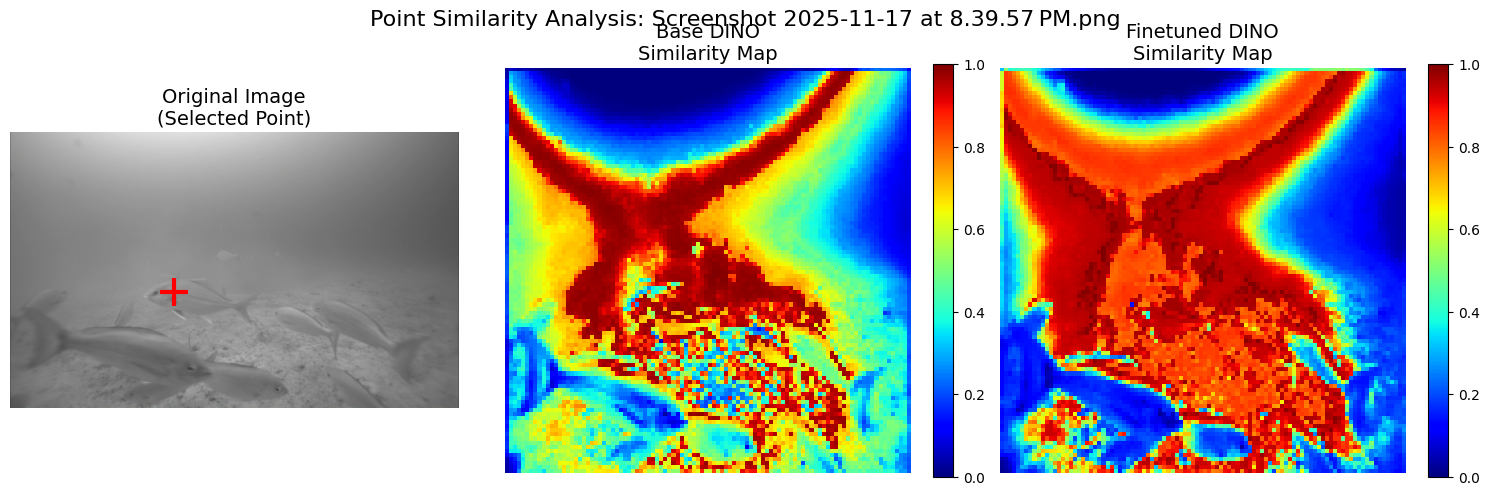

In [2]:
# Example 3: Fish image
img_path = 'Datasets/fish/Screenshot 2025-11-17 at 8.39.57 PM.png'  # Change to your image path
point_x, point_y = 822, 800  # Change to your desired point coordinates

fig = visualize_similarity(img_path, point_x, point_y, base_model, finetuned_model)
plt.savefig(f'similarity_{Path(img_path).stem}_x{point_x}_y{point_y}.png', dpi=200, bbox_inches='tight')
plt.show()
